## This notebook evalutes LogisticRegression
> Model parameters are itterated overa and the model is refined for the best accuracy.  Evaluation metrics are shown at each itteration of the model.  Successful improvements are included in the final notebook and unsuccessful methods attempted are included toward the bottom of this notebook.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

# For producing decision tree diagrams.
from IPython.core.display import Image, display

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Set the randomizer seed so results are the same each time
np.random.seed(0)

raw_data = pd.read_csv(r"../../data/covtype.csv") #https://www.kaggle.com/uciml/forest-cover-type-dataset
train_df = pd.read_csv(r"../../data/train.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data
test_df = pd.read_csv(r"../../data/test.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data

# Build Train and Test Datasets

In [2]:
test_labeled = raw_data[15120:]

test_labeled

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
15120,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,1
15121,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,1
15122,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,1
15123,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,1
15124,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [3]:
# show that this matches the above
test_df

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,...,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565887,581008,2396,153,20,85,17,108,240,237,118,...,0,0,0,0,0,0,0,0,0,0
565888,581009,2391,152,19,67,12,95,240,237,119,...,0,0,0,0,0,0,0,0,0,0
565889,581010,2386,159,17,60,7,90,236,241,130,...,0,0,0,0,0,0,0,0,0,0
565890,581011,2384,170,15,60,5,90,230,245,143,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# create correct labels df with index
test_labels_correct = pd.DataFrame(data = test_labeled, 
                                   index = test_df.loc[:, "Id"],
                                  columns = ["Cover_Type"])

# overwrite last value from NaN to correct label
test_labels_correct.loc[581012, "Cover_Type"] = 3

# cast back to int
test_labels_correct = test_labels_correct.astype("int32")

test_labels_correct

,Cover_Type
Id,
15121,1
15122,1
15123,1
15124,1
15125,1
...,...
581008,3
581009,3
581010,3


In [5]:
# extract labels from training data
train_labels_df = train_df.loc[:, "Cover_Type"]

# extract training data except labels and ID column
train_df = train_df.loc[:, (train_df.columns != "Cover_Type") & 
                        (train_df.columns != "Id")]

train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# extract indices of testing data for scoring
test_index_df = test_df.loc[:, "Id"]

# extract test data except ID column
test_df = test_df.loc[:, test_df.columns != "Id"]

test_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,0
1,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,0
2,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,0
3,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,0
4,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def PrintResults():
    # generate and print classification report
    print(classification_report(test_labels_correct, log_predictions_df))

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(log_model, test_df, test_labels_correct,
                                     display_labels= [str(number) for number in range(1, 8)],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        fig = plt.gcf()
        fig.set_size_inches(8,5)

    plt.show()

    # calculate and print accuracy
    print("Overall accuracy: " + 
          str(round(100*metrics.accuracy_score(test_labels_correct, log_predictions_df),2)) + "%")

# Build Base Model as starting point
> Simple logistic regression model with no parameters to set starting point# Build Base Model as starting point

In [8]:
# create initial model
log_model = LogisticRegression()

# fit to training data
log_model.fit(train_df, train_labels_df)

# supply the test_df to log_model and create predictions
log_predictions = log_model.predict(test_df)

# converts predictions from np array to pd dataframe
log_predictions_df = pd.DataFrame(data = log_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

              precision    recall  f1-score   support

           1       0.58      0.37      0.46    209679
           2       0.74      0.41      0.53    281141
           3       0.44      0.41      0.43     33595
           4       0.03      0.65      0.06       587
           5       0.04      0.47      0.07      7333
           6       0.08      0.20      0.11     15207
           7       0.11      0.65      0.19     18350

    accuracy                           0.40    565892
   macro avg       0.29      0.45      0.26    565892
weighted avg       0.62      0.40      0.47    565892



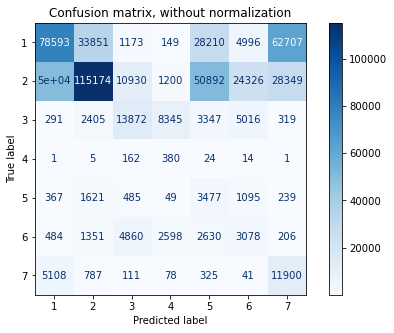

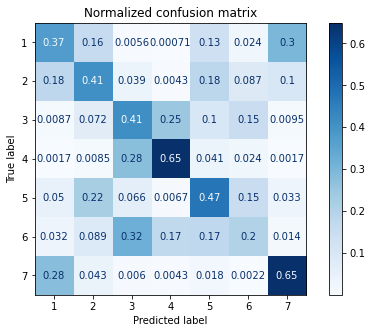

Overall accuracy: 40.02%


In [9]:
PrintResults()

### Accuracy: 40.02
> This sets a low starting point

# Add Weighting to Account for Test Data populations
> We know from the EDA that the test data has a significantly different number of samples per cover type than the training data.  By weighting the cover types based off the test data samples we can improve the model performance. Add Weighting to Account for Test Data populations

In [10]:
weights = np.bincount(log_predictions)[1:] / log_predictions.shape[0]
weights = dict(enumerate(weights.flatten(), 1))

weights

{1: 0.23876287348115896,
 2: 0.2742466760441922,
 3: 0.05582867402260502,
 4: 0.022617389890650513,
 5: 0.1571059495451429,
 6: 0.06815081322937946,
 7: 0.183287623786871}

              precision    recall  f1-score   support

           1       0.61      0.51      0.56    209679
           2       0.71      0.56      0.62    281141
           3       0.31      0.19      0.23     33595
           4       0.02      0.01      0.01       587
           5       0.06      0.34      0.09      7333
           6       0.13      0.27      0.17     15207
           7       0.13      0.50      0.21     18350

    accuracy                           0.50    565892
   macro avg       0.28      0.34      0.27    565892
weighted avg       0.60      0.50      0.54    565892



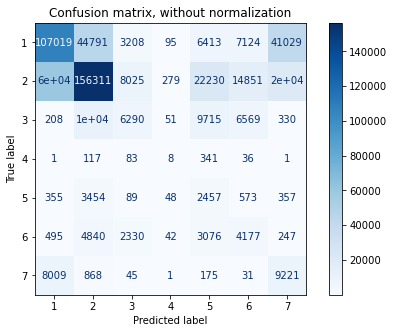

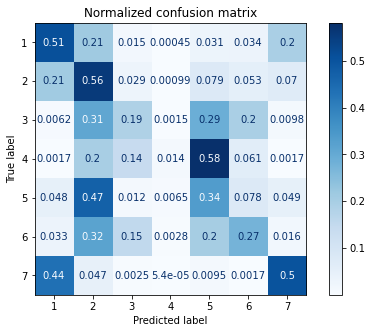

Overall accuracy: 50.45%


In [11]:
## Create current best classifier
log_model = LogisticRegression(class_weight = weights)

# fit to training data
log_model.fit(train_df, train_labels_df)

# supply the test_df to log_model and create predictions
log_predictions = log_model.predict(test_df)

# converts predictions from np array to pd dataframe
log_predictions_df = pd.DataFrame(data = log_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

log_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           log_predictions_df["Cover_Type"].to_numpy())

PrintResults()

### Accuracy 50.45% - Huge Improvement:
> ~10% improvement by simply adding the weights.  Now lets see what other refinements can be made.  

# Run Gid Search and Loop to find best parameters
Started with wider window and then narrowed down around range of interest.  Performed GridSearch and manual loop to confirm best parameters

In [12]:
## Use grid search to evaluate parameters

# choose variables for grid search
# parameters={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
parameters={"C":np.logspace(0,2,40), "penalty":["l2"]}# l1 lasso l2 ridge

# build classifier
classifier = GridSearchCV(LogisticRegression(solver="liblinear", multi_class="auto", class_weight = weights), 
                          param_grid = parameters, cv = 10,  
                          scoring = "accuracy", n_jobs=4)

# fit classifier to training data
classifier.fit(train_df, train_labels_df)

# make predictions of test data
predictions = classifier.predict(test_df)

In [13]:
print("Best parameters = ", classifier.best_params_)

# calculate and print accuracy
print("Overall accuracy: " + 
      str(round(100*metrics.accuracy_score(test_labels_correct, predictions),2)) + "%")

Best parameters =  {'C': 1.125335582600765, 'penalty': 'l2'}
Overall accuracy: 61.63%


In [14]:
## Use manual loop to evaluate parameters - faster than Gridsearch

# use to find large window
# parameters={"C":np.logspace(-3,3,20), "penalty":["l1","l2"]}# l1 lasso l2 ridge

parameters={"C":np.logspace(0,2,100), "penalty":["l2"]}# l1 lasso l2 ridge

top_accuracy, top_p, top_c = 0,0, 0
for p in parameters['penalty']:
    for c in parameters['C']:
    
        # build classifier
        classifier = LogisticRegression(C = c, penalty = p, solver="liblinear", multi_class="auto", class_weight = weights)

        # fit classifier to training data
        classifier.fit(train_df, train_labels_df)

        # make predictions of test data
        predictions = classifier.predict(test_df)
        
        accuracy = metrics.accuracy_score(test_labels_correct, predictions)
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            top_p = p
            top_c = c
        

print("Penalty:",top_p," IRS:%.20f"%top_c)
# calculate and print accuracy
print("Accuracy: " + str(round(100*top_accuracy,2)) + "%")

Penalty: l2  IRS:43.28761281083059486718
Accuracy: 61.45%


              precision    recall  f1-score   support

           1       0.65      0.57      0.60    209679
           2       0.72      0.71      0.72    281141
           3       0.68      0.16      0.26     33595
           4       0.07      0.37      0.11       587
           5       0.07      0.27      0.11      7333
           6       0.35      0.37      0.36     15207
           7       0.33      0.87      0.48     18350

    accuracy                           0.61    565892
   macro avg       0.41      0.48      0.38    565892
weighted avg       0.66      0.61      0.62    565892



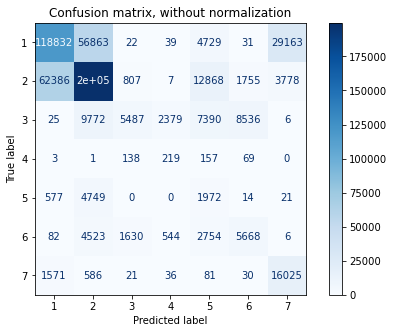

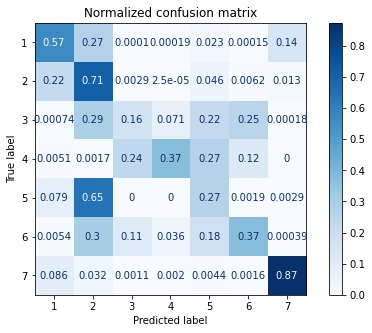

Overall accuracy: 61.45%


In [15]:
## Create current best classifier
log_model = LogisticRegression(C=top_c, penalty = 'l2', solver="liblinear", 
                               multi_class="auto", class_weight = weights)

# fit to training data
log_model.fit(train_df, train_labels_df)

# supply the test_df to log_model and create predictions
log_predictions = log_model.predict(test_df)

# converts predictions from np array to pd dataframe
log_predictions_df = pd.DataFrame(data = log_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

log_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           log_predictions_df["Cover_Type"].to_numpy())

PrintResults()

## Another significant improvement in the model boosting the score > 61%
> This was the best logistic regression model achieved.  This was loaded into the final notebook.

# Remove outliers from training data
> By Removing outliers from the training data the model can be trained to not be overfit on the training data.

In [16]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [17]:
# loop through all columns to see if there are any outliers
for column in train_df.columns:
    if outlier_function(train_df, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(train_df, column)[2], column))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points
There are 3597 outliers in Wilderness_Area1
There are 499 outliers in Wilderness_Area2
There are 355 outliers in Soil_Type1
There are 623 outliers in Soil_Type2
There are 962 outliers in Soil_Type3
There are 843 outliers in Soil_Type4
There are 165 outliers in Soil_Type5
There are 650 outliers in Soil_Type6
There are 1 outliers in Soil_Type8
There are 10 outliers in Soil_Type9
There are 2142 outliers in Soil_Type10
There are 406 outliers in Soil_Type11
There are 227 outliers in Soil_Type12
There are 476 outliers in Soil_Type13
There are 169 outliers in Soil_Type14
There are 114 outliers in Soil_Type16
There are 612 outliers in Soil_Type17
There are 60 outliers in Soil_Type18
There a

In [18]:
# From RFE below, we know these are the key features
# 15 most significant features according to RFE are 
# ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
# 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
# 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4', 
# 'Soil_Type3', 'Soil_Type10']

# RFE = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
#        'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
#        'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4', 
#        'Soil_Type3', 'Soil_Type10']


# Let's remove Fire Point outliers
RFE = ['Horizontal_Distance_To_Fire_Points']

ftr_train_df = train_df.copy()
ftr_train_labels_df = train_labels_df.copy()

for column in RFE:
    # Drop Values below 1Q
    indexNames = ftr_train_df[ftr_train_df[column] < 
                      outlier_function(ftr_train_df, column)[0]].index
    ftr_train_df = ftr_train_df.drop(indexNames)
    ftr_train_labels_df = ftr_train_labels_df.drop(indexNames)
    
    # Drop Values above 3Q
    indexNames = ftr_train_df[ftr_train_df[column] > 
                      outlier_function(ftr_train_df, column)[1]].index
    ftr_train_df = ftr_train_df.drop(indexNames)
    ftr_train_labels_df = ftr_train_labels_df.drop(indexNames)

In [19]:
## Use manual loop to evaluate parameters

# use to find large window
# parameters={"C":np.logspace(-3,3,20), "penalty":["l1","l2"]}# l1 lasso l2 ridge

parameters={"C":np.logspace(0,2,100), "penalty":["l1","l2"]}# l1 lasso l2 ridge

top_accuracy, top_p, top_c = 0,0, 0
for p in parameters['penalty']:
    for c in parameters['C']:
    
        # build classifier
        classifier = LogisticRegression(C = c, penalty = p, solver="liblinear", multi_class="auto", class_weight = weights)

        # fit classifier to training data
        classifier.fit(ftr_train_df, ftr_train_labels_df)

        # make predictions of test data
        predictions = classifier.predict(test_df)
        
        accuracy = metrics.accuracy_score(test_labels_correct, predictions)
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            top_p = p
            top_c = c
        

print("Penalty:",top_p," IRS:%.4f"%top_c)
# calculate and print accuracy
print("Accuracy: " + str(round(100*top_accuracy,2)) + "%")

Penalty: l2  IRS:1.5199
Accuracy: 61.11%


              precision    recall  f1-score   support

           1       0.64      0.58      0.61    209679
           2       0.74      0.69      0.71    281141
           3       0.69      0.17      0.27     33595
           4       0.07      0.38      0.12       587
           5       0.08      0.33      0.12      7333
           6       0.35      0.43      0.39     15207
           7       0.32      0.88      0.46     18350

    accuracy                           0.61    565892
   macro avg       0.41      0.49      0.38    565892
weighted avg       0.66      0.61      0.62    565892



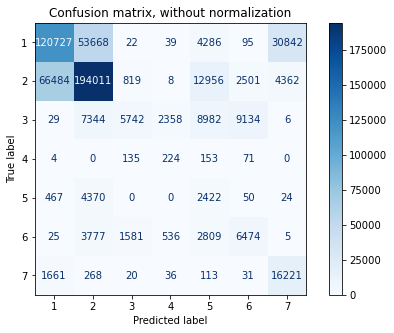

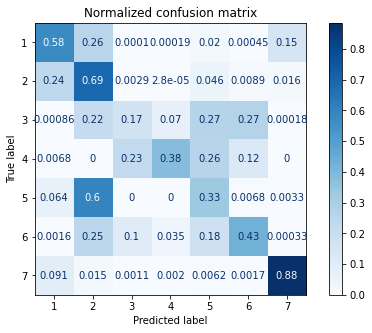

Overall accuracy: 61.11%


In [20]:
## Create current best classifier
log_model = LogisticRegression(C=top_c, penalty = top_p, solver="liblinear", 
                               multi_class="auto", class_weight = weights, max_iter = 2000)

# fit to training data
log_model.fit(ftr_train_df, ftr_train_labels_df)

# supply the test_df to log_model and create predictions
log_predictions = log_model.predict(test_df)

# converts predictions from np array to pd dataframe
log_predictions_df = pd.DataFrame(data = log_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

log_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           log_predictions_df["Cover_Type"].to_numpy())

PrintResults()

## Additional marginal improvement to > 61%
> This really helped with the confusion between cover type 5/6 and 2.

# Methods tried that didn't improve the model accuracy
----------------------------------------------------------------------------------------------

### Recursive Feature Elimination
The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.
First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a featureimportances attribute.
Then, the least important features are pruned from current set of features.
That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), \
                   n_features_to_select=15, step=10, verbose=5)
rfe_selector.fit(train_df, train_labels_df)
rfe_support = rfe_selector.get_support()
rfe_feature = train_df.loc[:,rfe_support].columns.tolist()
print('\n',str(len(rfe_feature)), 'most significant features according to RFE are ')
print(rfe_feature)

Fitting estimator with 54 features.
Fitting estimator with 44 features.
Fitting estimator with 34 features.
Fitting estimator with 24 features.

 15 most significant features according to RFE are 
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type3', 'Soil_Type10']


In [22]:
sf_train_df = train_df[rfe_feature]
sf_test_df = test_df[rfe_feature]

In [23]:
## Use manual loop to evaluate parameters

# use to find large window
# parameters={"C":np.logspace(-3,3,20), "penalty":["l1","l2"]}# l1 lasso l2 ridge

parameters={"C":np.logspace(0,2,100), "penalty":["l1","l2"]}# l1 lasso l2 ridge

top_accuracy, top_p, top_c = 0,0, 0
for p in parameters['penalty']:
    for c in parameters['C']:
    
        # build classifier
        classifier = LogisticRegression(C = c, penalty = p, solver="liblinear", multi_class="auto", class_weight = weights)

        # fit classifier to training data
        classifier.fit(sf_train_df, train_labels_df)

        # make predictions of test data
        predictions = classifier.predict(sf_test_df)
        
        accuracy = metrics.accuracy_score(test_labels_correct, predictions)
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            top_p = p
            top_c = c
        

print("Penalty:",top_p," IRS:%.4f"%top_c)
# calculate and print accuracy
print("Accuracy: " + str(round(100*top_accuracy,2)) + "%")

Penalty: l2  IRS:62.8029
Accuracy: 52.8%


### Results
> While the accuracy of this model is down it is interesting that we can get an accuracy score this close with only 15 parameters
----------------------------------------------------------------------------------------------------------

# Transform Data
> From the EDA we know that a few of the distributions are skewed.  So perform a log transformation to see if this helps with the model.

In [24]:
def CleanDataset(df, label_df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64), label_df[indices_to_keep].astype(np.float64)

In [25]:
# Take the log of skewed columns:
# Hillshade_9am
# Hillshade_Noon
# Slope
# Horizontal_Distance_To_Hydrology

tf_train_df = train_df.copy()
tf_train_labels_df = train_labels_df.copy()

tf_train_df['log_Hillshade_9am'] = np.log(tf_train_df['Hillshade_9am'])
tf_train_df['log_Hillshade_Noon'] = np.log(tf_train_df['Hillshade_Noon'])
tf_train_df['log_Slope'] = np.log(tf_train_df['Slope'])
tf_train_df['log_Horizontal_Distance_To_Hydrology'] = np.log(tf_train_df['Horizontal_Distance_To_Hydrology'])

tf_train_df = tf_train_df.drop(columns=["Hillshade_9am"])
tf_train_df = tf_train_df.drop(columns=["Hillshade_Noon"])
tf_train_df = tf_train_df.drop(columns=["Slope"])
tf_train_df = tf_train_df.drop(columns=["Horizontal_Distance_To_Hydrology"])

tf_train_df, tf_train_labels_df = CleanDataset(tf_train_df,tf_train_labels_df)


C:\Users\scott\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
## Use manual loop to evaluate parameters

# use to find large window
# parameters={"C":np.logspace(-3,3,20), "penalty":["l1","l2"]}# l1 lasso l2 ridge

parameters={"C":np.logspace(0,2,100), "penalty":["l1","l2"]}# l1 lasso l2 ridge

top_accuracy, top_p, top_c = 0,0, 0
for p in parameters['penalty']:
    for c in parameters['C']:
    
        # build classifier
        classifier = LogisticRegression(C = c, penalty = p, solver="liblinear", multi_class="auto", class_weight = weights)

        # fit classifier to training data
        classifier.fit(tf_train_df, tf_train_labels_df)

        # make predictions of test data
        predictions = classifier.predict(test_df)
        
        accuracy = metrics.accuracy_score(test_labels_correct, predictions)
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            top_p = p
            top_c = c
        

print("Penalty:",top_p," IRS:%.4f"%top_c)
# calculate and print accuracy
print("Accuracy: " + str(round(100*top_accuracy,2)) + "%")

Penalty: l1  IRS:35.9381
Accuracy: 5.91%


# Try Feature Engineering to see if we can improve model

In [27]:
train_df['Average_Hillshade'] = ((train_df['Hillshade_9am']**2 +
                                 train_df['Hillshade_9am']**2 + train_df['Hillshade_9am']**2)/3)**0.5

test_df['Average_Hillshade'] = ((test_df['Hillshade_9am']**2 +
                                 test_df['Hillshade_9am']**2 + test_df['Hillshade_9am']**2)/3)**0.5

In [28]:
train_df['Total_Distance_to_Hydrology'] = (train_df['Horizontal_Distance_To_Hydrology']**2 + 
                                           train_df['Vertical_Distance_To_Hydrology']**2)**0.5
test_df['Total_Distance_to_Hydrology'] = (test_df['Horizontal_Distance_To_Hydrology']**2 + 
                                          test_df['Vertical_Distance_To_Hydrology']**2)**0.5
train_df = train_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
train_df = train_df.drop(columns=["Vertical_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Vertical_Distance_To_Hydrology"])

In [29]:
train_df['Total_Distance_to_Hydrology'] = ((train_df['Total_Distance_to_Hydrology'] - train_df['Total_Distance_to_Hydrology'].min()) /
                (train_df['Total_Distance_to_Hydrology'].max() - train_df['Total_Distance_to_Hydrology'].min()))

test_df['Total_Distance_to_Hydrology'] = ((test_df['Total_Distance_to_Hydrology'] - test_df['Total_Distance_to_Hydrology'].min()) /
                 (test_df['Total_Distance_to_Hydrology'].max() - test_df['Total_Distance_to_Hydrology'].min()))

train_df['Roadway_Distance_Normal'] = ((train_df['Horizontal_Distance_To_Roadways'] - train_df['Horizontal_Distance_To_Roadways'].min()) /
                (train_df['Horizontal_Distance_To_Roadways'].max() - train_df['Horizontal_Distance_To_Roadways'].min()))

test_df['Roadway_Distance_Normal'] = ((test_df['Horizontal_Distance_To_Roadways'] - test_df['Horizontal_Distance_To_Roadways'].min()) /
                 (test_df['Horizontal_Distance_To_Roadways'].max() - test_df['Horizontal_Distance_To_Roadways'].min()))

train_df['Fire_Points_Distance_Normal'] = ((train_df['Horizontal_Distance_To_Fire_Points'] - train_df['Horizontal_Distance_To_Fire_Points'].min()) /
                (train_df['Horizontal_Distance_To_Fire_Points'].max() - train_df['Horizontal_Distance_To_Fire_Points'].min()))

test_df['Fire_Points_Distance_Normal'] = ((test_df['Horizontal_Distance_To_Fire_Points'] - test_df['Horizontal_Distance_To_Fire_Points'].min()) /
                 (test_df['Horizontal_Distance_To_Fire_Points'].max() - test_df['Horizontal_Distance_To_Fire_Points'].min()))

train_df['Elevation_Normal'] = ((train_df['Elevation'] - train_df['Elevation'].min()) /
                (train_df['Elevation'].max() - train_df['Elevation'].min()))

test_df['Elevation_Normal'] = ((test_df['Elevation'] - test_df['Elevation'].min()) /
                 (test_df['Elevation'].max() - test_df['Elevation'].min()))

train_df = train_df.drop(columns=["Horizontal_Distance_To_Roadways"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Roadways"])
train_df = train_df.drop(columns=["Horizontal_Distance_To_Fire_Points"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Fire_Points"])
train_df = train_df.drop(columns=["Elevation"])
test_df = test_df.drop(columns=["Elevation"])